# Training Demo CBCF

In [1]:
# --- STEP 0: Generate synthetic fields and hazard mask, save as sample.npz ---

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path as MplPath
from pathlib import Path

# ---------- Grid + synthetic fields ----------
def make_grid(nx=300, ny=200):
    lon = np.linspace(-15, 30, nx)
    lat = np.linspace(35, 60, ny)
    lon2d, lat2d = np.meshgrid(lon, lat)
    return lon2d, lat2d, lon, lat

def gaussian_blob(lon2d, lat2d, lon0, lat0, amp, sx, sy):
    """Create one Gaussian blob centered at (lon0, lat0)."""
    return amp * np.exp(-(((lon2d - lon0)/sx)**2 + ((lat2d - lat0)/sy)**2))

def random_fields(lon2d, lat2d, seed=0):
    """Generate synthetic wind and gust fields with several blobs."""
    rng = np.random.default_rng(seed)
    wind = 8 + 0.1*(lon2d - lon2d.mean()) + 0.05*(lat2d - lat2d.mean())
    gust = 10 + 0.05*(lon2d - lon2d.mean()) + 0.08*(lat2d - lat2d.mean())
    for _ in range(rng.integers(3, 6)):
        lon0, lat0 = rng.uniform(-10, 25), rng.uniform(38, 57)
        amp = rng.uniform(10, 18)
        wind += gaussian_blob(lon2d, lat2d, lon0, lat0, amp, 3, 2)
        gust += gaussian_blob(lon2d, lat2d, lon0+0.5, lat0, amp*1.2, 2.5, 1.8)
    return wind, gust

def build_mask(wind, gust, thr_w=18, thr_g=22):
    """Binary hazard mask where both fields exceed thresholds."""
    return ((wind >= thr_w) & (gust >= thr_g)).astype(np.uint8)

# ---------- Mask → Polygons ----------
def mask_to_polygons(mask, lon2d, lat2d, level=0.5):
    fig, ax = plt.subplots()
    cs = ax.contour(lon2d, lat2d, mask, levels=[level])
    polygons = []
    if hasattr(cs, "collections"):
        for coll in cs.collections:
            for path in coll.get_paths():
                v = path.vertices
                if len(v) > 10:
                    polygons.append([(float(x), float(y)) for x, y in v])
    elif hasattr(cs, "get_paths"):  # matplotlib >=3.9
        for path in cs.get_paths():
            v = path.vertices
            if len(v) > 10:
                polygons.append([(float(x), float(y)) for x, y in v])
    plt.close(fig)
    return polygons

# ---------- Polygons → Mask ----------
def polygons_to_mask(polys, lon2d, lat2d):
    ny, nx = lon2d.shape
    points = np.column_stack((lon2d.ravel(), lat2d.ravel()))
    mask = np.zeros((ny, nx), np.uint8)
    for poly in polys:
        path = MplPath(poly, closed=True)
        inside = path.contains_points(points).reshape(ny, nx)
        mask |= inside.astype(np.uint8)
    return mask

# ---------- Generate one example ----------
lon2d, lat2d, lon, lat = make_grid()
wind, gust = random_fields(lon2d, lat2d, seed=3)
mask = build_mask(wind, gust)
polys = mask_to_polygons(mask, lon2d, lat2d)
mask2 = polygons_to_mask(polys, lon2d, lat2d)

# ---------- Save sample ----------
out = Path("warn_demo")
out.mkdir(exist_ok=True)
np.savez(out / "sample.npz",
         lon=lon, lat=lat,
         wind=wind, gust=gust,
         mask=mask, mask2=mask2)
print(f"Generated {len(polys)} polygons and saved to {out/'sample.npz'}")


Generated 1 polygons and saved to warn_demo\sample.npz


# 1

Found components: 4, polygons extracted: 4


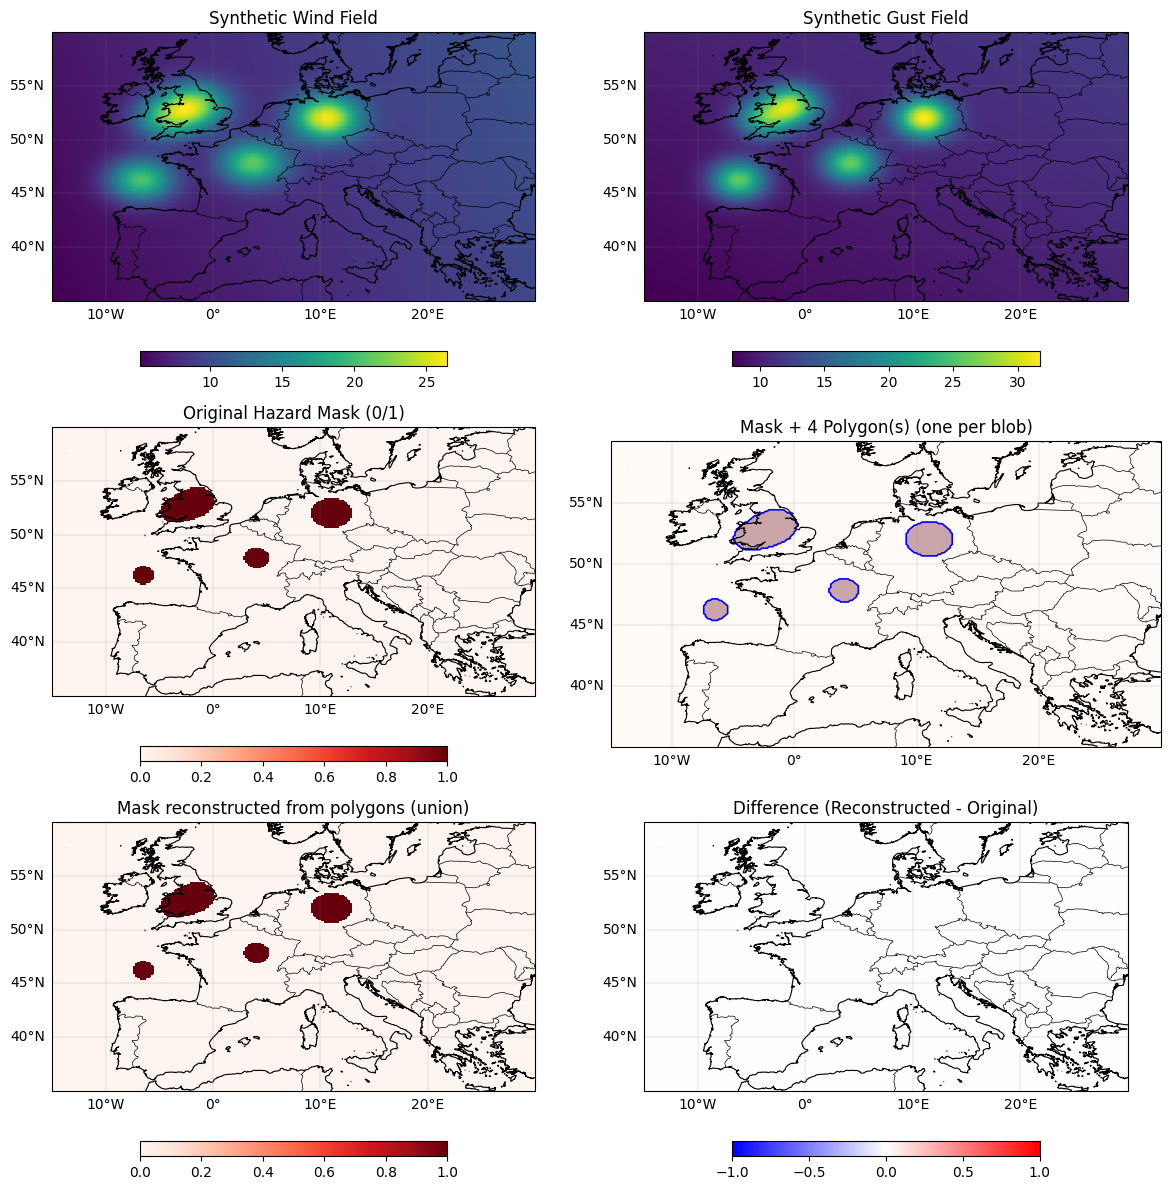

Mean absolute difference: 0.000000
Total differing pixels: 0


In [2]:
# --- STEP 1: One polygon per blob + reconstruct mask from polygon list (with Cartopy map) ---

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

# ---------- Load sample ----------
data = np.load(Path("warn_demo") / "sample.npz")
lon, lat = data["lon"], data["lat"]
wind, gust, mask = data["wind"], data["gust"], data["mask"]
lon2d, lat2d = np.meshgrid(lon, lat)
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

# ---------- Connected-components ----------
def label_connected_4(mask01: np.ndarray):
    mask01 = (mask01 > 0).astype(np.uint8)
    H, W = mask01.shape
    labels = np.zeros_like(mask01, dtype=np.int32)
    next_label = 1
    for y in range(H):
        for x in range(W):
            if mask01[y, x] == 1 and labels[y, x] == 0:
                stack = [(y, x)]
                labels[y, x] = next_label
                while stack:
                    cy, cx = stack.pop()
                    for ny, nx in ((cy-1, cx), (cy+1, cx), (cy, cx-1), (cy, cx+1)):
                        if 0 <= ny < H and 0 <= nx < W:
                            if mask01[ny, nx] == 1 and labels[ny, nx] == 0:
                                labels[ny, nx] = next_label
                                stack.append((ny, nx))
                next_label += 1
    return labels, (next_label - 1)

# ---------- Robust path iterator ----------
def iter_paths_from_contourset(cs):
    if hasattr(cs, "collections"):  # older mpl
        for coll in cs.collections:
            if hasattr(coll, "get_paths"):
                for p in coll.get_paths():
                    yield p
    if hasattr(cs, "get_paths"):     # mpl 3.9+
        for p in cs.get_paths():
            yield p

# ---------- Extract one polygon per blob ----------
def component_to_polygon(comp_mask, lon2d, lat2d, level=0.5, min_vertices=6):
    fig, ax = plt.subplots()
    cs = ax.contour(lon2d, lat2d, comp_mask.astype(float), levels=[level])
    best = None
    best_len = -1
    for p in iter_paths_from_contourset(cs):
        v = p.vertices
        if v.shape[0] >= min_vertices and v.shape[0] > best_len:
            best = v
            best_len = v.shape[0]
    plt.close(fig)
    if best is None:
        return None
    if not np.allclose(best[0], best[-1]):
        best = np.vstack([best, best[:1]])
    return [(float(x), float(y)) for x, y in best]

# ---------- Build polygon list ----------
labels, ncomp = label_connected_4(mask)
polygons = []
for cid in range(1, ncomp+1):
    comp = (labels == cid)
    poly = component_to_polygon(comp, lon2d, lat2d)
    if poly is not None:
        polygons.append(poly)
print(f"Found components: {ncomp}, polygons extracted: {len(polygons)}")

# ---------- Convert polygon list -> mask ----------
def polygons_to_mask_union(polygons, lon2d, lat2d):
    ny, nx = lon2d.shape
    points = np.column_stack((lon2d.ravel(), lat2d.ravel()))
    mask_out = np.zeros((ny, nx), dtype=np.uint8)
    for poly in polygons:
        if len(poly) < 3:
            continue
        path = MplPath(poly, closed=True)
        inside = path.contains_points(points)
        mask_out |= inside.reshape(ny, nx).astype(np.uint8)
    return mask_out

mask_from_polys = polygons_to_mask_union(polygons, lon2d, lat2d)

# ---------- Helper: add Cartopy map ----------
def setup_map(ax):
    proj = ccrs.PlateCarree()
    ax.set_extent(extent, crs=proj)
    ax.coastlines(resolution="10m", color="black", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5)
    gl.top_labels = gl.right_labels = False

# ---------- Helper: plot polygons correctly (no connections) ----------
def draw_polygons(ax, polygons, color="blue", linewidth=1.2):
    proj = ccrs.PlateCarree()
    for poly in polygons:
        verts = np.asarray(poly)
        if len(verts) < 3:
            continue
        if not np.allclose(verts[0], verts[-1]):
            verts = np.vstack([verts, verts[:1]])
        n = len(verts)
        codes = np.full(n, MplPath.LINETO, dtype=np.uint8)
        codes[0] = MplPath.MOVETO
        codes[-1] = MplPath.CLOSEPOLY
        path = MplPath(verts, codes)
        patch = PathPatch(path, transform=proj, fill=False, edgecolor=color, linewidth=linewidth)
        ax.add_patch(patch)

# ---------- Plot 3 rows ----------
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(3, 2, figsize=(12, 12), subplot_kw={"projection": proj})
(ax1, ax2), (ax3, ax4), (ax5, ax6) = axes

# Row 1: fields
for ax in (ax1, ax2):
    setup_map(ax)
im1 = ax1.pcolormesh(lon, lat, wind, transform=proj, cmap="viridis")
ax1.set_title("Synthetic Wind Field"); fig.colorbar(im1, ax=ax1, fraction=0.046, orientation="horizontal")
im2 = ax2.pcolormesh(lon, lat, gust, transform=proj, cmap="viridis")
ax2.set_title("Synthetic Gust Field"); fig.colorbar(im2, ax=ax2, fraction=0.046, orientation="horizontal")

# Row 2: original mask + polygons
for ax in (ax3, ax4):
    setup_map(ax)
im3 = ax3.pcolormesh(lon, lat, mask, transform=proj, cmap="Reds", vmin=0, vmax=1)
ax3.set_title("Original Hazard Mask (0/1)"); fig.colorbar(im3, ax=ax3, fraction=0.046, orientation="horizontal")

im4 = ax4.pcolormesh(lon, lat, mask, transform=proj, cmap="Reds", alpha=0.35, vmin=0, vmax=1)
draw_polygons(ax4, polygons, color="blue")
ax4.set_title(f"Mask + {len(polygons)} Polygon(s) (one per blob)")

# Row 3: reconstructed mask + difference
for ax in (ax5, ax6):
    setup_map(ax)
im5 = ax5.pcolormesh(lon, lat, mask_from_polys, transform=proj, cmap="Reds", vmin=0, vmax=1)
ax5.set_title("Mask reconstructed from polygons (union)")
fig.colorbar(im5, ax=ax5, fraction=0.046, orientation="horizontal")

diff = mask_from_polys - mask
im6 = ax6.pcolormesh(lon, lat, diff, transform=proj, cmap="bwr", vmin=-1, vmax=1)
ax6.set_title("Difference (Reconstructed - Original)")
fig.colorbar(im6, ax=ax6, fraction=0.046, orientation="horizontal")

plt.tight_layout()
plt.show()

# ---------- Quantitative check ----------
diff_mean = np.abs(mask_from_polys - mask).mean()
diff_sum  = int(np.sum(np.abs(mask_from_polys - mask)))
print(f"Mean absolute difference: {diff_mean:.6f}")
print(f"Total differing pixels: {diff_sum}")


# 2

In [3]:
# --- STEP 2 (variant): Train full-field MLP to map (wind, gust) → mask ---

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path

# ----- Load the single example -----
data = np.load(Path("warn_demo") / "sample.npz")
wind, gust, mask = data["wind"], data["gust"], data["mask"]

ny, nx = mask.shape
N = ny * nx

# Flatten full fields into one long vector
x1 = (wind - wind.min()) / (wind.max() - wind.min())
x2 = (gust - gust.min()) / (gust.max() - gust.min())
X_np = np.stack([x1.ravel(), x2.ravel()], axis=1)  # [N, 2]
Y_np = mask.ravel().astype(np.float32)[:, None]     # [N, 1]

X = torch.tensor(X_np, dtype=torch.float32)
Y = torch.tensor(Y_np, dtype=torch.float32)

# ----- Define a small MLP -----
class FullFieldMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=128, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, out_dim), nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = FullFieldMLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ----- Train -----
epochs = 500
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, Y)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Loss = {loss.item():.6f}")

torch.save(model.state_dict(), Path("warn_demo") / "fullfield_model.pt")
print("Model saved → warn_demo/fullfield_model.pt")


Epoch  50 | Loss = 0.085152
Epoch 100 | Loss = 0.022197
Epoch 150 | Loss = 0.013035
Epoch 200 | Loss = 0.010125
Epoch 250 | Loss = 0.008527
Epoch 300 | Loss = 0.007416
Epoch 350 | Loss = 0.006577
Epoch 400 | Loss = 0.005863
Epoch 450 | Loss = 0.005337
Epoch 500 | Loss = 0.004927
Model saved → warn_demo/fullfield_model.pt


# 3

Polygons extracted: true=1, predicted=1


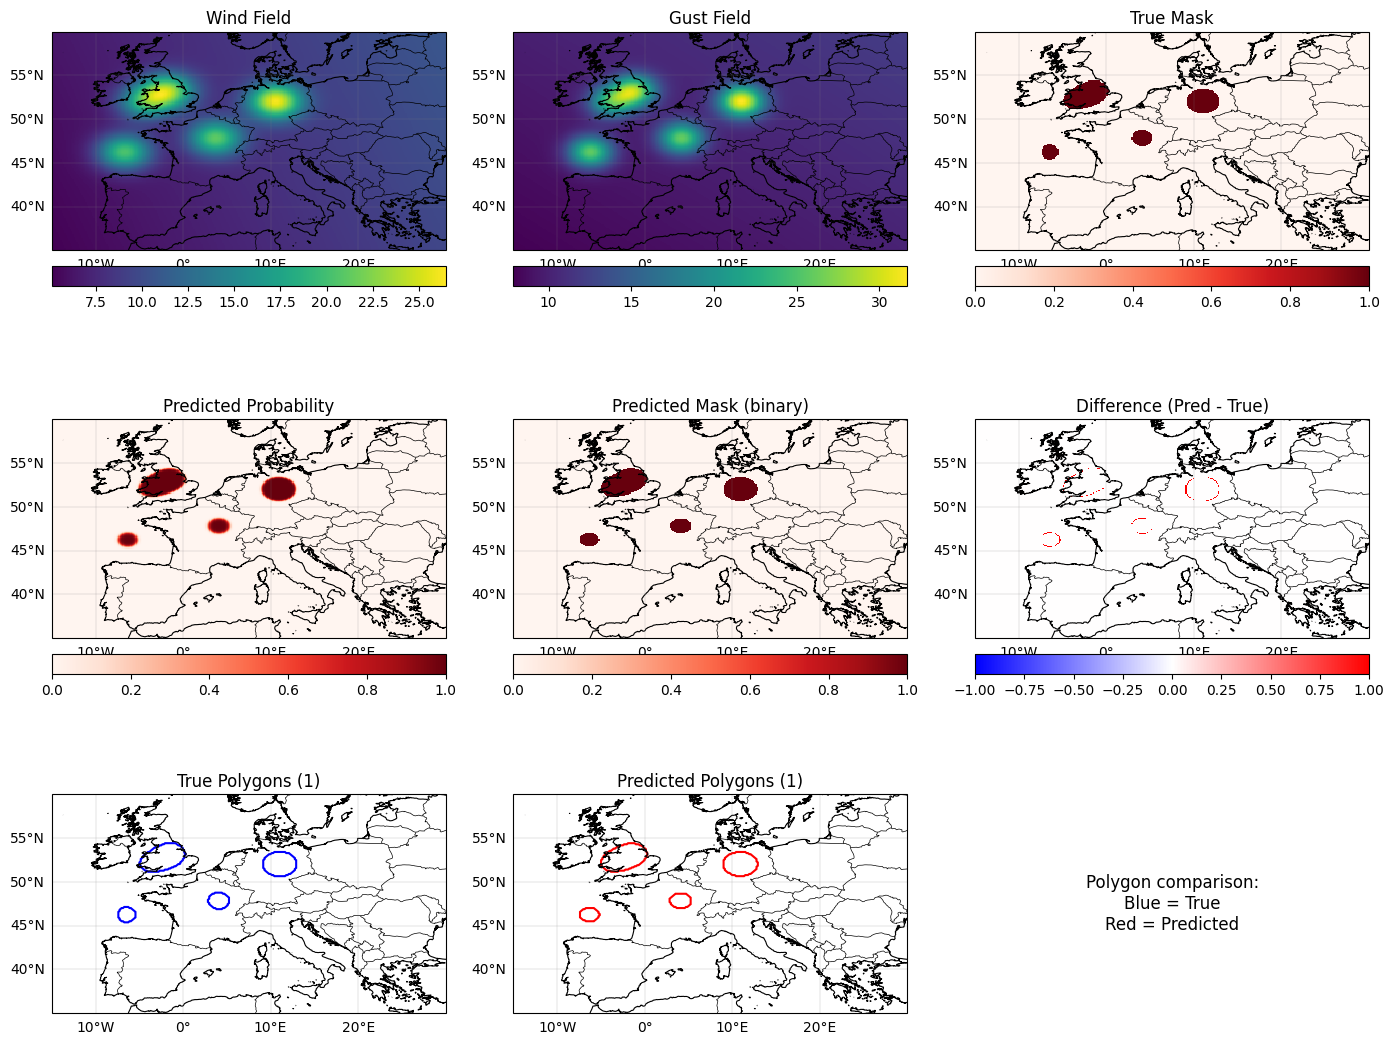

In [4]:
# --- STEP 3 (final clean version): Apply trained model and visualize result with correct polygons ---

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import torch.nn as nn

# ---------- Load data ----------
data = np.load(Path("warn_demo") / "sample.npz")
lon, lat = data["lon"], data["lat"]
wind, gust, mask_true = data["wind"], data["gust"], data["mask"]
ny, nx = mask_true.shape
extent = [lon.min(), lon.max(), lat.min(), lat.max()]
lon2d, lat2d = np.meshgrid(lon, lat)

# ---------- Normalize input ----------
x1 = (wind - wind.min()) / (wind.max() - wind.min())
x2 = (gust - gust.min()) / (gust.max() - gust.min())
X_np = np.stack([x1.ravel(), x2.ravel()], axis=1)
X = torch.tensor(X_np, dtype=torch.float32)

# ---------- Define model ----------
class FullFieldMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=128, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, out_dim), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

# ---------- Load trained model ----------
model = FullFieldMLP()
model.load_state_dict(torch.load(Path("warn_demo") / "fullfield_model.pt", map_location="cpu"))
model.eval()

# ---------- Predict ----------
with torch.no_grad():
    pred = model(X).squeeze().numpy().reshape(ny, nx)
mask_pred = (pred > 0.5).astype(np.uint8)

# ---------- Extract polygons ----------
def mask_to_polygons(mask, lon2d, lat2d, level=0.5, min_vertices=5):
    fig, ax = plt.subplots()
    cs = ax.contour(lon2d, lat2d, mask, levels=[level])
    polygons = []
    if hasattr(cs, "collections"):
        collections = cs.collections
    elif hasattr(cs, "get_paths"):
        collections = [cs]
    else:
        collections = []
    for coll in collections:
        paths = getattr(coll, "get_paths", lambda: [])()
        for p in paths:
            v = p.vertices
            if v.shape[0] >= min_vertices:
                polygons.append([(float(x), float(y)) for x, y in v])
    plt.close(fig)
    return polygons

true_polys = mask_to_polygons(mask_true, lon2d, lat2d)
pred_polys = mask_to_polygons(mask_pred, lon2d, lat2d)

print(f"Polygons extracted: true={len(true_polys)}, predicted={len(pred_polys)}")

# ---------- Helper: map setup ----------
def setup_map(ax):
    proj = ccrs.PlateCarree()
    ax.set_extent(extent, crs=proj)
    ax.coastlines(resolution="10m", color="black", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="gray", alpha=0.5)
    gl.top_labels = gl.right_labels = False

# ---------- Helper: draw polygons (no connections) ----------
from matplotlib.patches import PathPatch
from matplotlib.path import Path as MplPath
import numpy as np
import cartopy.crs as ccrs

def draw_polygons(ax, polygons, color="blue", linewidth=1.5):
    """
    Draw each polygon separately.
    If any Path contains disjoint rings, they are split at large jumps.
    No connecting lines anymore.
    """
    proj = ccrs.PlateCarree()
    for poly in polygons:
        verts = np.asarray(poly)
        if len(verts) < 3:
            continue

        # Find breaks: large jumps indicate separate polygons (disjoint paths)
        d = np.sqrt(np.sum(np.diff(verts, axis=0)**2, axis=1))
        breaks = np.where(d > 2.0)[0]  # threshold in degrees; tune if needed
        segments = []
        start = 0
        for b in breaks:
            segments.append(verts[start:b+1])
            start = b+1
        segments.append(verts[start:])

        for seg in segments:
            if len(seg) < 3:
                continue
            if not np.allclose(seg[0], seg[-1]):
                seg = np.vstack([seg, seg[:1]])
            n = len(seg)
            codes = np.full(n, MplPath.LINETO, dtype=np.uint8)
            codes[0] = MplPath.MOVETO
            codes[-1] = MplPath.CLOSEPOLY
            path = MplPath(seg, codes)
            patch = PathPatch(path, transform=proj, fill=False,
                              edgecolor=color, linewidth=linewidth)
            ax.add_patch(patch)


# ---------- Plot 3 rows ----------
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(14, 12))

# Row 1: Wind / Gust / True Mask
ax1 = plt.subplot(3, 3, 1, projection=proj)
ax2 = plt.subplot(3, 3, 2, projection=proj)
ax3 = plt.subplot(3, 3, 3, projection=proj)
for ax in (ax1, ax2, ax3): setup_map(ax)
im1 = ax1.pcolormesh(lon, lat, wind, transform=proj, cmap="viridis"); ax1.set_title("Wind Field")
fig.colorbar(im1, ax=ax1, orientation="horizontal", pad=0.04)
im2 = ax2.pcolormesh(lon, lat, gust, transform=proj, cmap="viridis"); ax2.set_title("Gust Field")
fig.colorbar(im2, ax=ax2, orientation="horizontal", pad=0.04)
im3 = ax3.pcolormesh(lon, lat, mask_true, transform=proj, cmap="Reds", vmin=0, vmax=1)
ax3.set_title("True Mask"); fig.colorbar(im3, ax=ax3, orientation="horizontal", pad=0.04)

# Row 2: Predicted Probability / Binary / Difference
ax4 = plt.subplot(3, 3, 4, projection=proj)
ax5 = plt.subplot(3, 3, 5, projection=proj)
ax6 = plt.subplot(3, 3, 6, projection=proj)
for ax in (ax4, ax5, ax6): setup_map(ax)
im4 = ax4.pcolormesh(lon, lat, pred, transform=proj, cmap="Reds", vmin=0, vmax=1)
ax4.set_title("Predicted Probability"); fig.colorbar(im4, ax=ax4, orientation="horizontal", pad=0.04)
im5 = ax5.pcolormesh(lon, lat, mask_pred, transform=proj, cmap="Reds", vmin=0, vmax=1)
ax5.set_title("Predicted Mask (binary)"); fig.colorbar(im5, ax=ax5, orientation="horizontal", pad=0.04)
im6 = ax6.pcolormesh(lon, lat, mask_pred - mask_true, transform=proj, cmap="bwr", vmin=-1, vmax=1)
ax6.set_title("Difference (Pred - True)"); fig.colorbar(im6, ax=ax6, orientation="horizontal", pad=0.04)

# Row 3: Polygons
ax7 = plt.subplot(3, 3, 7, projection=proj)
ax8 = plt.subplot(3, 3, 8, projection=proj)
ax9 = plt.subplot(3, 3, 9, projection=proj)
for ax in (ax7, ax8): setup_map(ax)
draw_polygons(ax7, true_polys, color="blue"); ax7.set_title(f"True Polygons ({len(true_polys)})")
draw_polygons(ax8, pred_polys, color="red"); ax8.set_title(f"Predicted Polygons ({len(pred_polys)})")
ax9.axis("off")
ax9.text(0.3, 0.5, "Polygon comparison:\nBlue = True\nRed = Predicted",
         fontsize=12, ha="center", va="center")

plt.tight_layout()
plt.show()
